# SDS 271 Final Project 
Group 1 Christy Yang, Vicky Xu, Xinran Bi, Yuzhang Fu
### Intro

In [113]:
#import libraries needed
import pandas as pd
import json
import branca.colormap
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker
import ipywidgets as widgets
from IPython.display import display
from ipyleaflet import Map, Choropleth, LegendControl
import geopandas as gpd
import branca.colormap
from ipywidgets import interactive_output
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import Dropdown
from ipywidgets import HTML
import matplotlib.ticker as ticker

In [154]:
class DataVisualizer:    
    def __init__(self, csv_file):
        """
        Initialize the DataVisualizer instance.

        Parameters:
        - csv_file (str): Path to the CSV file containing the data.
        """
        
        
        self.data = pd.read_csv(csv_file)
        self.data = self.data.rename(columns={"First Tooltip": "Value"})
        
        self.regions = {
            "AFR": ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon", "Cape Verde", "Central African Republic", "Chad", "Comoros", "Ivory Coast", "Democratic Republic of the Congo", "Equatorial Guinea", "Eritrea", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mozambique", "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "São Tomé and Príncipe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", "South Sudan", "Eswatini", "Togo", "Uganda", "Tanzania", "Zambia", "Zimbabwe"],
            "AMR": ["Antigua and Barbuda", "Argentina", "Bahamas", "Barbados", "Belize", "Bolivia", "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "Ecuador", "El Salvador", "Grenada", "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama", "Paraguay", "Peru", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Suriname", "Trinidad and Tobago", "United States", "Uruguay", "Venezuela"],
            "SEAR": ["Bangladesh", "Bhutan", "North Korea", "India", "Indonesia", "Maldives", "Myanmar", "Nepal", "Sri Lanka", "Thailand", "Timor-Leste"],
            "EUR": ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Kazakhstan", "Kyrgyzstan", "Latvia", "Lithuania", "Luxembourg", "Malta", "Moldova", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", "Poland", "Portugal", "Romania", "Russia", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Tajikistan", "Turkey", "Turkmenistan", "Ukraine", "United Kingdom", "Uzbekistan"],
            "EMR": ["Afghanistan", "Bahrain", "Djibouti", "Egypt", "Iran", "Iraq", "Palestine", "Jordan", "Kuwait", "Lebanon", "Libya", "Morocco", "Oman", "Pakistan", "Qatar", "Saudi Arabia", "Somalia", "Sudan", "Syria", "Tunisia", "United Arab Emirates", "Yemen"],
            "WPR": ["Australia", "Brunei", "Cambodia", "China", "Cook Islands", "Fiji", "Japan", "Kiribati", "Laos", "Malaysia", "Marshall Islands", "Micronesia", "Mongolia", "Nauru", "New Zealand", "Niue", "Palau", "Papua New Guinea", "Philippines", "Samoa", "Singapore", "Solomon Islands", "South Korea", "Taiwan", "Tonga", "Tuvalu", "Vanuatu", "Vietnam"]
        }
        
        self.df_region = None  # Initialize df_region attribute, result of aggregation by region

    @staticmethod
    def check_same_entries_in_Indicator(self):
        """
        Check whether all entries in the 'Indicator' column are identical.

        Returns:
        bool: True if all entries are identical, False otherwise.
        """
        return self.data['Indicator'].nunique() == 1
    
    @staticmethod
    def split_by_indicator(self):
        """
        Split dataframe if there are multiple unique values in the "Indicator" column
        
        Returns:
        filtered_datasets: Splited datafranes within each has an identical indicator value
        """
        arr = self.data["Indicator"].unique() 
        filtered_datasets = []
        if not self.check_same_entries_in_Indicator(self):
            for i in range(0, len(arr)):
                filtered_data = self.data[self.data['Indicator'] == arr[i]]
                filtered_datasets.append(filtered_data)
        return filtered_datasets

    @staticmethod
    def plot_by_location(self, period, column_name=None, location=None):
        """
        Plot the value for Dim1 = 'Total' at a designated period for different locations.

        Parameters:
        - period (int): The specified year.
        - column_name (str, optional): Indicator for plotting.
        - location (str, optional): Location to filter the data.

        Notes:
        If column_name is not provided and all entries in the 'Indicator' column are identical,
        it uses the first entry in the 'Indicator' column as the column name.
        If the 'Dim1' column includes categories 'Urban', 'Total', and 'Rural', the function proceeds with plotting;
        otherwise, it notifies that the 'Dim1' column does not meet the specified criteria.
        """
        # Determine column name if not provided and all entries in 'Indicator' are identical
        if column_name is None and self.data['Indicator'].nunique() == 1:
            column_name = self.data['Indicator'].iloc[0]

        # Filter data for the specified period
        filtered_data = self.data[self.data['Period'] == period]

        # Filter data based on the specified location(s)
        if location is not None:
            if isinstance(location, str):
                location = [location]
            filtered_data = filtered_data[filtered_data['Location'].isin(location)]

        if 'Dim1' in self.data.columns and set(self.data['Dim1'].unique()) == {'Urban', 'Total', 'Rural'}:
            # Filter data for Dim1 categories 'Urban' and 'Rural'
            urban_rural_data = filtered_data[filtered_data['Dim1'].isin(['Urban', 'Rural'])]

            # Check if there's any data to plot
            if not urban_rural_data.empty:
                # Plotting for Urban and Rural categories side-by-side for each location
                unique_locations = urban_rural_data['Location'].unique()
                num_locations = len(unique_locations)

                fig, axes = plt.subplots(1, num_locations, figsize=(16, 6), sharey=True)
                fig.suptitle(f'{column_name} for Dim1 = Urban/Rural at Period {period}', fontsize=16)

                for i, loc in enumerate(unique_locations):
                    loc_data = urban_rural_data[urban_rural_data['Location'] == loc]
                    sns.barplot(x='Dim1', y='Value', data=loc_data, ax=axes[i])
                    axes[i].set_title(f'Location: {loc}', fontsize=14)
                    axes[i].set_xlabel('Dim1', fontsize=14)
                    axes[i].set_ylabel(column_name, fontsize=14)

                plt.tight_layout()
                plt.show()
            else:
                print("No data available for the specified combination.")
        else:
            print("Dim1 column does not meet the specified criteria.")
            
    @staticmethod
    def plot_by_location_male_female(self, period, column_name=None, location=None):
        """
        Plot the value of "First Tooltip" for Dim1 = 'Both sexes' at a designated period for different sexes.

        Parameters:
        - period (int): The specified year.
        - column_name (str, optional): Indicator for plotting.
        - location (str, optional): Location to filter the data.

        Notes:
        If column_name is not provided and all entries in the 'Indicator' column are identical,
        it uses the first entry in the 'Indicator' column as the column name.
        If the 'Dim1' column includes categories 'Both sexes', 'Male', and 'Female', the function proceeds with plotting;
        otherwise, it notifies that the 'Dim1' column does not meet the specified criteria.
        """
        # Determine column name if not provided and all entries in 'Indicator' are identical
        if column_name is None and self.data['Indicator'].nunique() == 1:
            column_name = self.data['Indicator'].iloc[0]

        # Filter data for the specified period
        filtered_data = self.data[self.data['Period'] == period]

        # Filter data based on the specified location(s)
        if location is not None:
            if isinstance(location, str):
                location = [location]
            filtered_data = filtered_data[filtered_data['Location'].isin(location)]

        if 'Dim1' in self.data.columns and set(self.data['Dim1'].unique()) == {'Male', 'Both sexes', 'Female'}:
            # Filter data for Dim1 categories 'Male' and 'Female'
            male_female_data = filtered_data[filtered_data['Dim1'].isin(['Male', 'Female'])]

            # Check if there's any data to plot
            if not male_female_data.empty:
                # Plotting for Male and Female categories side-by-side for each location
                unique_locations = male_female_data['Location'].unique()
                num_locations = len(unique_locations)

                fig, axes = plt.subplots(1, num_locations, figsize=(16, 6), sharey=True)
                fig.suptitle(f'{column_name} for Dim1 = Male/Female at Period {period}', fontsize=16)

                for i, loc in enumerate(unique_locations):
                    loc_data = male_female_data[male_female_data['Location'] == loc]
                    sns.barplot(x='Dim1', y='Value', data=loc_data, ax=axes[i])
                    axes[i].set_title(f'Location: {loc}', fontsize=14)
                    axes[i].set_xlabel('Dim1', fontsize=14)
                    axes[i].set_ylabel(column_name, fontsize=14)

                plt.tight_layout()
                plt.show()
            else:
                print("No data available for the specified combination.")
        else:
            print("Dim1 column does not meet the specified criteria.")
    
    @staticmethod
    def aggregate_data_by_region_and_year(self):
        """
        Aggregate data by Region, Year, Dim1, and calculate the mean of 'Value'.
        
        Returns: The aggregated dataframe which is stored in the `df_region` attribute.
        """
        df = pd.DataFrame(self.data)

        df['Region'] = df['Location'].apply(lambda x: next((region for region, countries in self.regions.items() if x in countries), None))

        # Group by Region, Year, Dim1 and calculate the mean of 'Value'
        self.df_region = df.groupby(['Region', 'Indicator','Period', 'Dim1'])['Value'].mean().reset_index()

        return self.df_region
    
    @staticmethod
    def prepare_data_for_plotting(self, location):
        """
        Prepares data for plotting based on the given country or region.

        Parameters:
        location (str): The country or region to filter the data.

        Returns:
        The filtered data and the title suffix.
        """
        # If df_region is not yet computed, run the aggregation
        if self.df_region is None:
            self.aggregate_data_by_region_and_year(self)

        # Check if the location is a region
        is_region = location in self.regions.keys()

        if is_region:
            # Filter data for the region
            mask = self.df_region["Region"] == location
            data_location = self.df_region[mask]
            title_suffix = f" in {location} (Region)"
        else:
            # Filter data for the specific location
            mask = self.data["Location"] == location
            data_location = self.data[mask]
            title_suffix = f" in {location}"

        return data_location, title_suffix
    
    
    @staticmethod
    def lineplot(self, location):
        """
        Generate a lineplot for the specified country or region.

        Parameters:
        - location (str): The country or region for the lineplot.
        """
        data_location, title_suffix = self.prepare_data_for_plotting(self,location)
        
        plt.figure(figsize=(12, 8))
        sns.lineplot(data=data_location, x='Period', y='Value', hue="Dim1")
        plt.title(f"Lineplot of {data_location['Indicator'].iloc[0]} {title_suffix} over Time")
        plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        plt.xlabel("Time", fontsize=14)
        plt.ylabel(data_location['Indicator'].iloc[0], fontsize=14)
        plt.legend(title='Dimension', bbox_to_anchor=(1, 1), fontsize=14)
        plt.style.use('fivethirtyeight')
        plt.show()

    
    @staticmethod
    def scatterplot(self, location):
        """
        Generate a scatterplot for the specified country or region.

        Parameters:
        - location (str): The country or region for the scatterplot.
        """
        data_location, title_suffix = self.prepare_data_for_plotting(self,location)
    
        plt.figure(figsize=(12, 8))
        sns.scatterplot(data=data_location, x='Period', y='Value', hue = "Dim1")
        plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
        plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
        plt.xlabel("Time", fontsize=14)
        plt.ylabel(f"{self.data.Indicator[0]}", fontsize=14)
        plt.legend(title='Dimension', bbox_to_anchor=(1, 1), fontsize=14)
        plt.title(f"{self.data.Indicator[0]} {title_suffix} over Time")
        plt.style.use('fivethirtyeight')
        plt.show()

    # barplot
    @staticmethod
    def aggregate_years(data):
        """
        Aggregate time periods in the 'Period' column of the given DataFrame into year bins.

        Parameters:
        - data (pd.DataFrame): The dataframe containing a 'Period' column to be aggregated.

        Returns: A modified dataframe with the 'Period' column values aggregated into broader time periods.
        """
        aggregated_df = data.copy()
    
        # Aggregate years 2000-2005, 2006-2010, 2011-2017
        aggregated_df['Period'] = aggregated_df['Period'].astype(str) 
    
        aggregated_df.loc[aggregated_df['Period'].between('2000', '2005'), 'Period'] = '2000-2005'
        aggregated_df.loc[aggregated_df['Period'].between('2006', '2010'), 'Period'] = '2006-2010'
        aggregated_df.loc[aggregated_df['Period'].between('2011', '2017'), 'Period'] = '2011-2017'
    
        return aggregated_df
    
    @staticmethod
    def barplot(self, location):
        """
        Create a barplot for the specified country or region. 
        Years(2000-2017) are aggregated to three period:
        2000-2005, 2006-2010, and 2011-2017. 
        
        Parameters:
        - location (str): The country or region for the lineplot.
        """
        data_location, title_suffix = self.prepare_data_for_plotting(self,location)
        
        df_location_aggregated = self.aggregate_years(data_location)
        #df_location_aggregated = aggregate_years(df_location)
    
        # Define the desired order for the legend labels
        legend_order = ['2000-2005', '2006-2010', '2011-2017']
    
        plt.figure(figsize=(12, 8))
        sns.barplot(data=df_location_aggregated, x='Dim1', y='Value', hue='Period', hue_order=legend_order)
        plt.xlabel("Time", fontsize=14)
        plt.ylabel(f"{df_location_aggregated['Indicator'].iloc[0]}", fontsize=14)
        plt.legend(title='Year', bbox_to_anchor=(1, 1), fontsize=14)
        plt.title(f"{df_location_aggregated['Indicator'].iloc[0]} {title_suffix} over Time")
        plt.style.use('fivethirtyeight')
        plt.show()
        

    @staticmethod
    def create_health_map_1(self, initial_year):
        """
        Create a heat geomap with a slider and dropdown to switch between years and 'Dim1' values.
        Update the map with a single layer based on user selection.

        Parameters:
        - initial_year (int): The initial year to display on the slider.
        """

        # Create a slider widget for the year
        year_slider = widgets.IntSlider(value=initial_year, min=self.data['Period'].min(), max=self.data['Period'].max(), description='Year')

        # Create a dropdown widget for selecting 'Dim1' values
        dim1_dropdown = Dropdown(options= self.data['Dim1'].unique().tolist(), value='Total', description='Dim1', style={'description_width': 'initial'})

        # Load a GeoDataFrame with country boundaries
        world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

        # Create the initial map
        m = Map(center=(20, 0), zoom=2)
        display(m)
        
        # Initial empty Choropleth layer
        choro_layer = None
        
        def update_map(year, selected_dim1):
            """
            Update the Choropleth map based on the specified year and dimension,
            removing the existing layer and adding a new Choropleth layer with the updated data.

            Parameters:
            - year (int): The year to filter the data.
            - selected_dim1 (str): The selected dimension (e.g., 'Total', 'Urban', 'Rural').
            """
            nonlocal choro_layer  # Use the outer variable

            # Clear existing Choropleth layer if it exists
            if choro_layer:
                m.remove_layer(choro_layer)

            # Filter for the specified year and dim1
            data_selected = self.data[(self.data['Period'] == year) & (self.data['Dim1'] == selected_dim1)]

            # Check if the filtered dataset is empty
            if data_selected.empty:
                # Print an error message
                print(f"No data available for the year {year} and dimension {selected_dim1}")
                return

            # Load a GeoDataFrame with country boundaries
            world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

            # Merge the dataset with the GeoDataFrame
            merged = world.set_index('name').join(data_selected.set_index('Location'))

            # Define the color scale
            color_scale = branca.colormap.linear.YlOrRd_09.scale(merged['Value'].min(), merged['Value'].max())

            # Create a Choropleth layer
            choro_layer = Choropleth(
                geo_data=merged.__geo_interface__,
                choro_data=dict(merged['Value']),
                colormap=color_scale,
                style={'fillOpacity': 0.8, 'dashArray': '5, 5'}
            )
     
            # Add the Choropleth layer and legend to the map
            m.add_layer(choro_layer)
            

        # Set up an observer to update the map when the slider or dropdown value changes
        output = interactive_output(update_map, {'year': year_slider, 'selected_dim1': dim1_dropdown})

        # Display the slider and dropdown
        display(widgets.VBox([year_slider, dim1_dropdown, output]))


In [155]:
file_path = 'data/safelySanitization.csv'
file_path_2 = 'data/HALElifeExpectancyAtBirth.csv'
file_path_3 = 'data/airPollutionDeathRate.csv'


# Instantiate the DataAnalyzer class
visualizer = DataVisualizer(file_path)
visualizer_2 = DataVisualizer(file_path_2)
visualizer_3 = DataVisualizer(file_path_3)

visualizer.data.head()
visualizer_2.data.head()
visualizer_3.data.head()

,Location,Dim2,Indicator,Period,Dim1,Value
0,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Both sexes,95.12 [85.12-104.3]
1,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Male,95.58 [85.5-106]
2,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Female,94.63 [84.55-103.9]
3,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Both sexes,211.1 [188.9-231.3]
4,Afghanistan,Total,Ambient and household air pollution attributab...,2016,Male,228.7 [204.6-253.6]


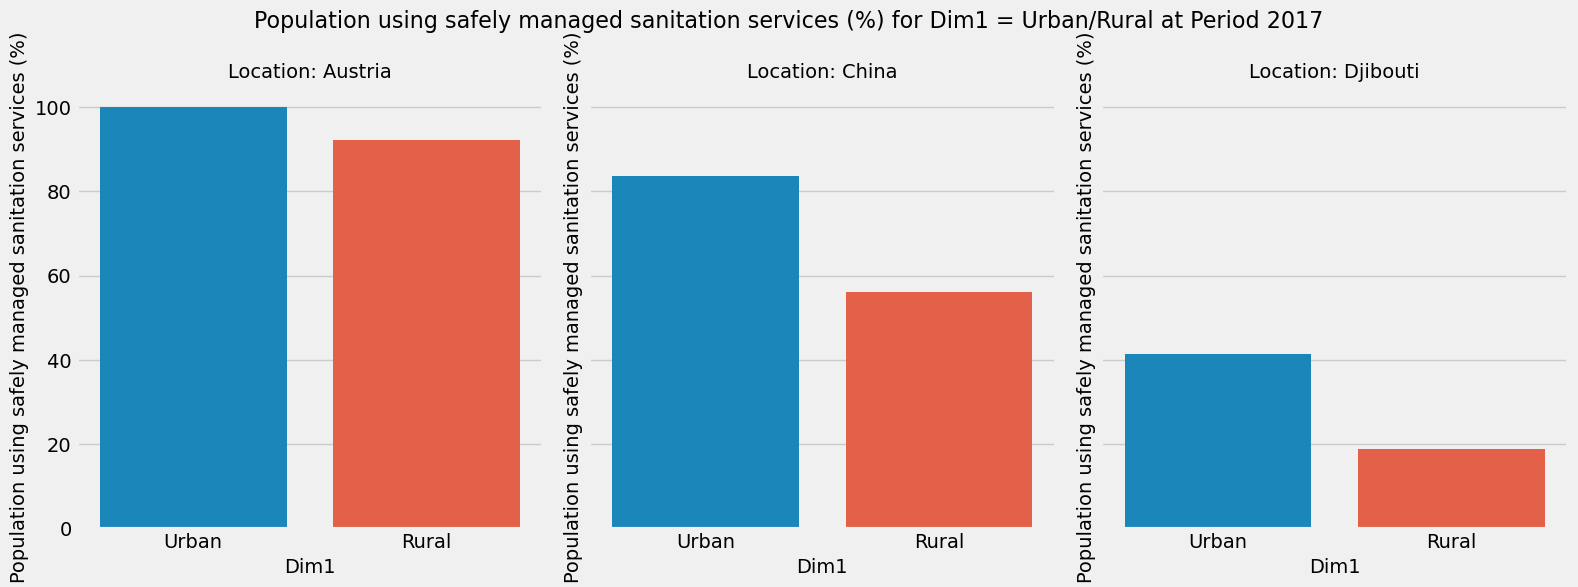

In [156]:
visualizer.plot_by_location(visualizer,2017, None, ["China","Austria","Djibouti"])

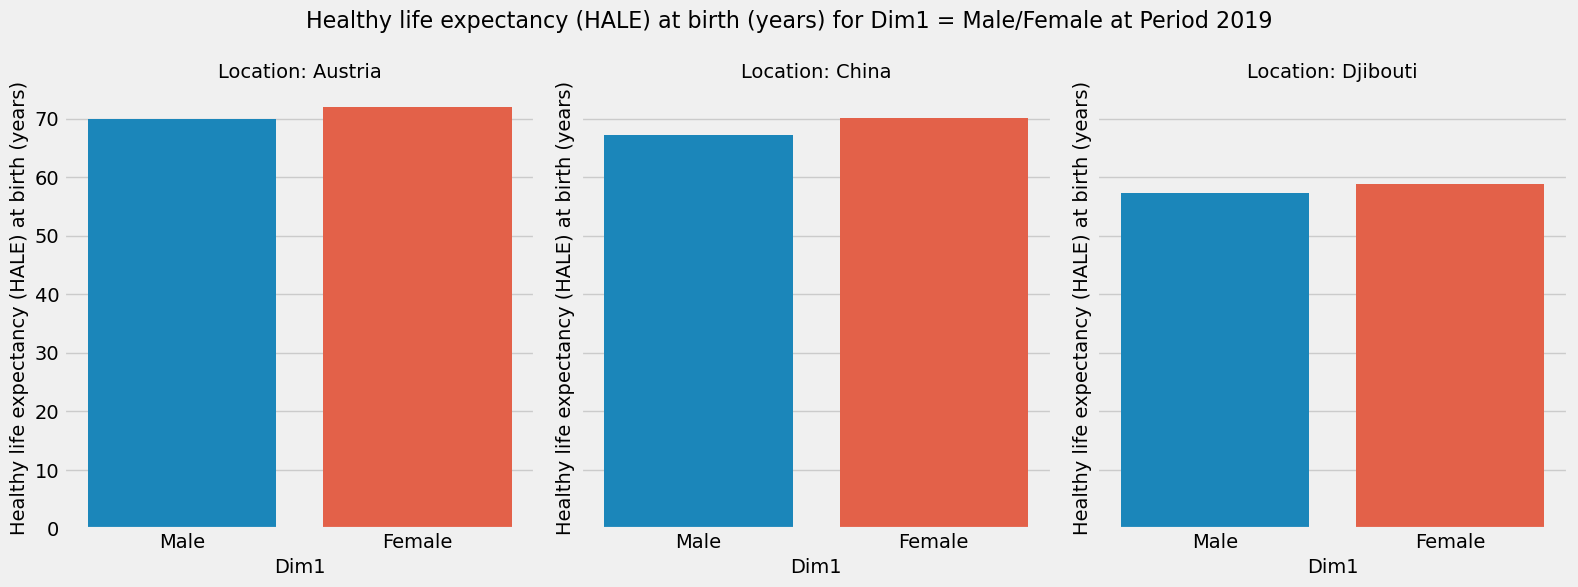

In [157]:
visualizer_2.plot_by_location_male_female(visualizer_2, 2019, None, ["China", "Austria", "Djibouti"])

In [158]:
visualizer_3.split_by_indicator(visualizer_3)

[         Location                                   Dim2  \
 0     Afghanistan                                  Total   
 1     Afghanistan                                  Total   
 2     Afghanistan                                  Total   
 6     Afghanistan           Lower respiratory infections   
 7     Afghanistan           Lower respiratory infections   
 ...           ...                                    ...   
 6577     Zimbabwe                                 Stroke   
 6578     Zimbabwe                                 Stroke   
 6582     Zimbabwe  Chronic obstructive pulmonary disease   
 6583     Zimbabwe  Chronic obstructive pulmonary disease   
 6584     Zimbabwe  Chronic obstructive pulmonary disease   
 
                                               Indicator  Period        Dim1  \
 0     Ambient and household air pollution attributab...    2016  Both sexes   
 1     Ambient and household air pollution attributab...    2016        Male   
 2     Ambient and househo

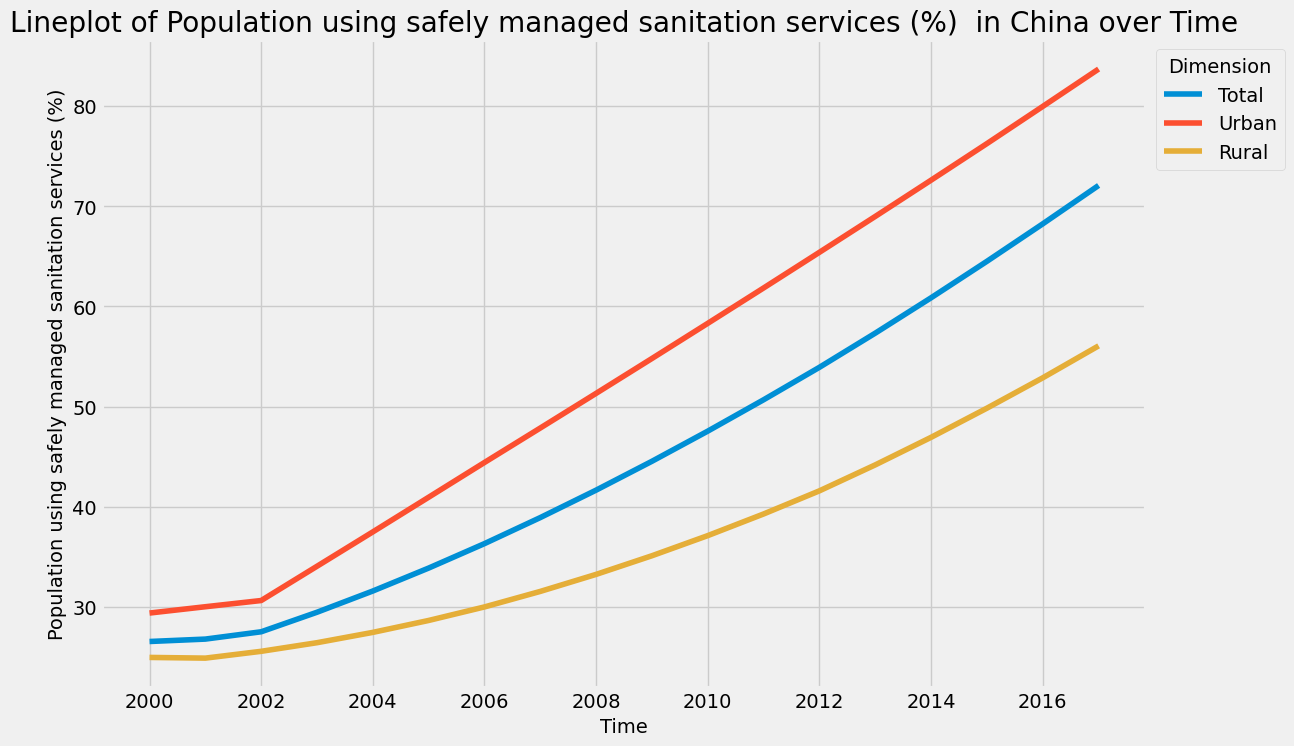

In [139]:
visualizer.lineplot(visualizer,"China")

In [ ]:
visualizer.scatterplot(visualizer, "China")

In [ ]:
visualizer.barplot(visualizer, "China")

In [ ]:
visualizer.create_health_map_1(visualizer, initial_year=2013)

In [ ]:
visualizer.lineplot(visualizer,location="AFR")

In [ ]:
help(visualizer)